In [1]:
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import scipy.signal as sig

In [2]:
# Set input path to run all analysis 
# folder with all raw pose data (dir_in_path) 
raw_pose_data_in_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\zeno_video_output'
# fps for zeno = 30
fps = 30

output_folder = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\zeno_depth_est_proxy'

In [3]:
def merge_bw_zv(bw_df, zv_df):

    print('total bw rows with id in video dataset') 
    print(len(zv_df))

    # merge bw data set rows with zeno videos rows 
        # merge bw data set rows with zeno videos rows 
        # id and date needs to be the same 
        # should only use each brainwalk visit once - once PWS_1 video per person 

    merged_bw_zv = []

    # Loop through each row in av_df
    for index, zv_row in zv_df.iterrows():
   
        current_id = zv_row['id_video']
        current_date = zv_row['visit_date_video']
        zv_row_df = pd.DataFrame([zv_row])

        # Find rows in brainwalk data set with same id and same date as current zv data 
        zv_in_bw_current_id_rows = bw_df[(bw_df['bw_id'] == current_id) & (bw_df['trialdate'] == current_date)]
        #zv_in_bw_current_id_date_rows = zv_in_bw_current_id_rows[zv_in_bw_current_id_rows['visit_date'] == current_date]
   
        if len(zv_in_bw_current_id_rows) == 1: 
            bw_row_to_merge = zv_in_bw_current_id_rows
            # merge bw and zv, store merged row
            merged_row = zv_row_df.merge(bw_row_to_merge, left_on='id_video', right_on='bw_id')
            merged_bw_zv.append(merged_row)
        
        # if more than one row for the id and date, pick one with least na values 
        elif len(zv_in_bw_current_id_rows) > 1:
            bw_row_to_merge = zv_in_bw_current_id_rows.loc[[zv_in_bw_current_id_rows.isna().sum(axis=1).idxmin()]]
            # merge bw and zv, store merged row
            merged_row = zv_row_df.merge(bw_row_to_merge, left_on='id_video', right_on='bw_id')
            merged_bw_zv.append(merged_row)

            print('multiple rows for the id and date combo')
            print(current_id)
            print(current_date)

        else: 
            print('No matching id and daterow from video vs mat')
            print(current_id)
            print(current_date)


    # merge all bw and zv data together 
    merged_bw_zv_df = pd.concat(merged_bw_zv)
    merged_bw_zv_df = merged_bw_zv_df.reset_index(drop=True) # reset index 

    # check same ID for each row 
    print('mismatched zeno video vs brainwalk id')
    print(sum(merged_bw_zv_df['id_video'] != merged_bw_zv_df['bw_id']))

    print('mismatched zeno video vs brainwalk date')
    print(sum(merged_bw_zv_df['visit_date_video'] != merged_bw_zv_df['trialdate']))

    # saved merged df for future reference 
#    merged_bw_zv_df.to_csv(os.path.join(out_path,  'zv_bw_merged_' + task + '.csv'))

    return merged_bw_zv_df

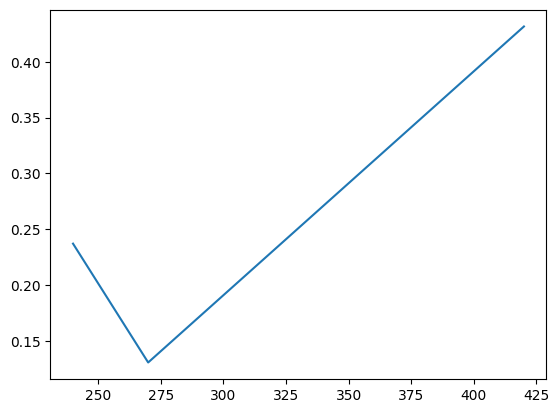

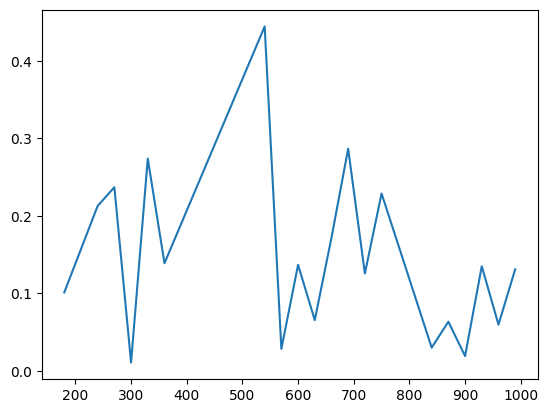

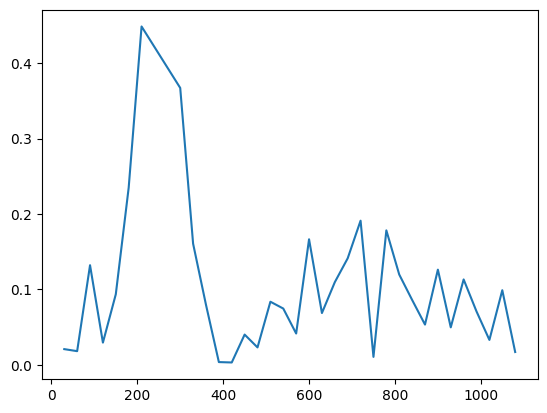

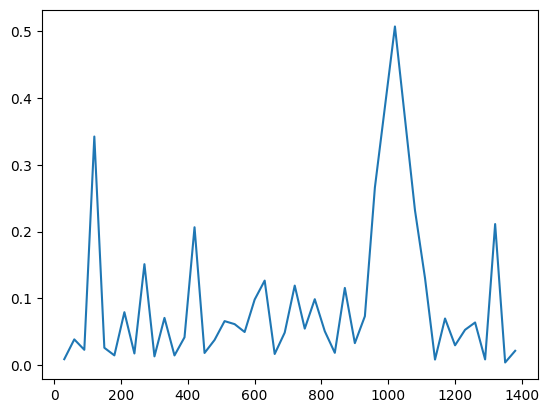

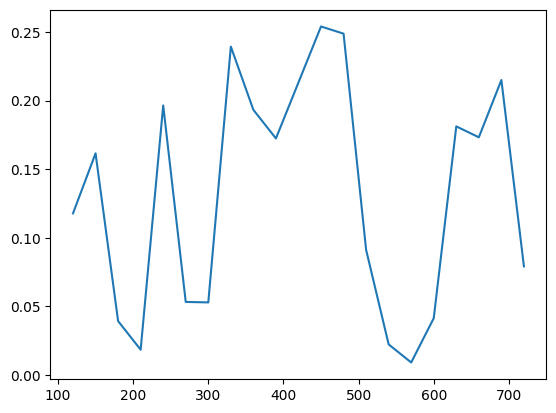

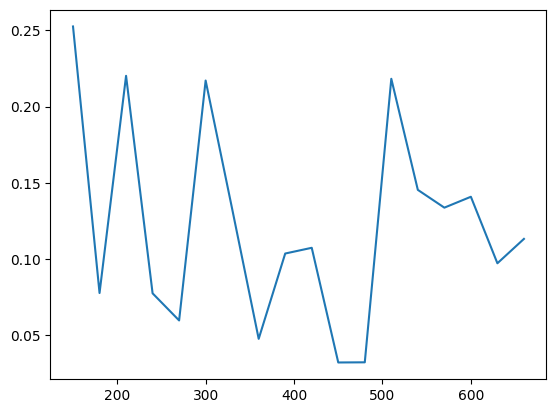

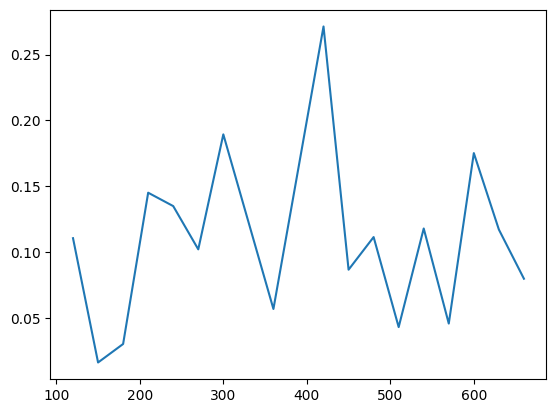

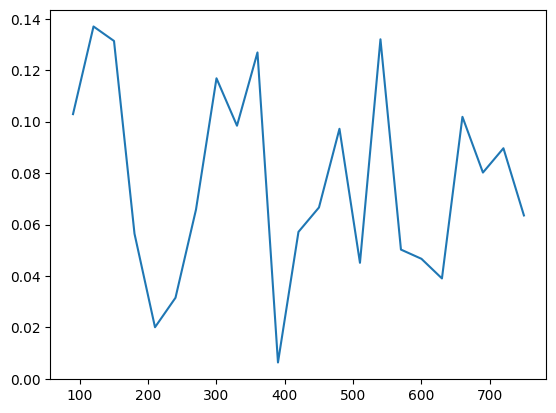

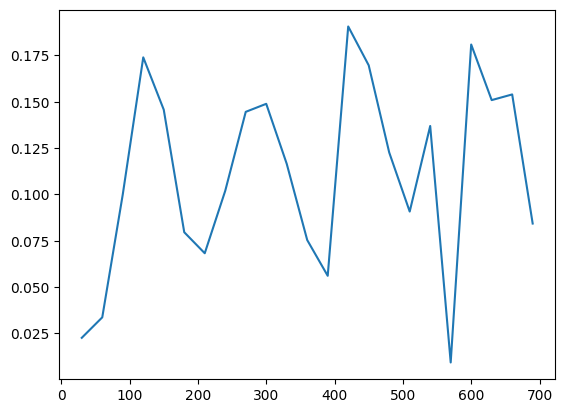

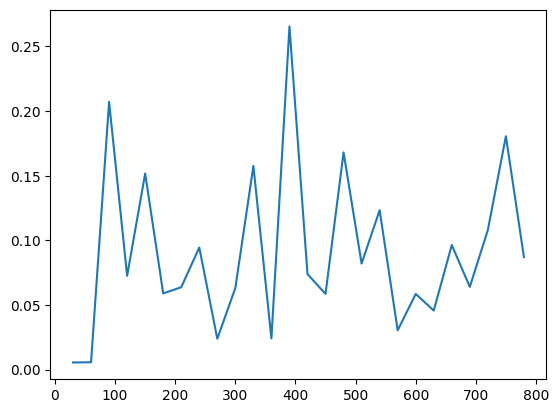

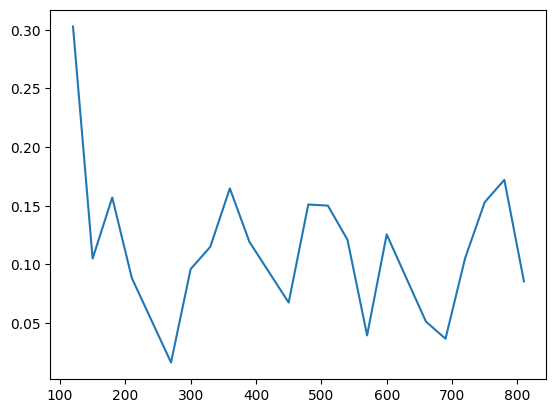

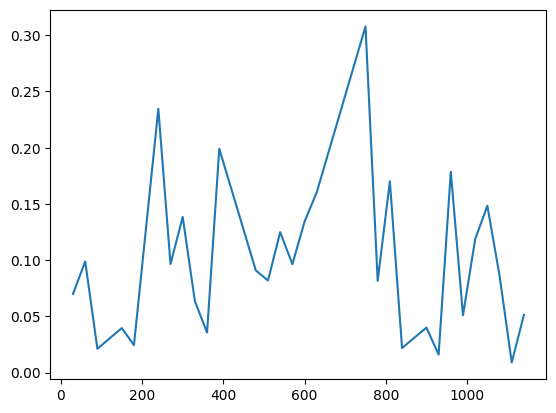

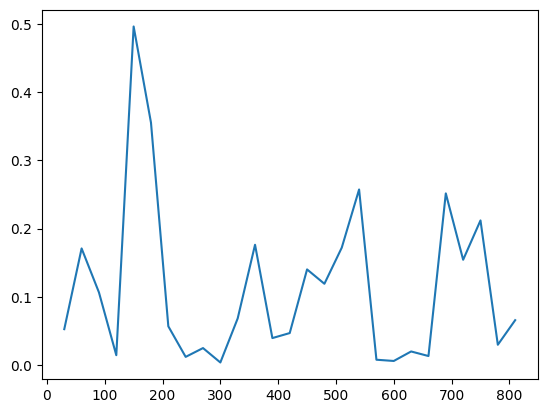

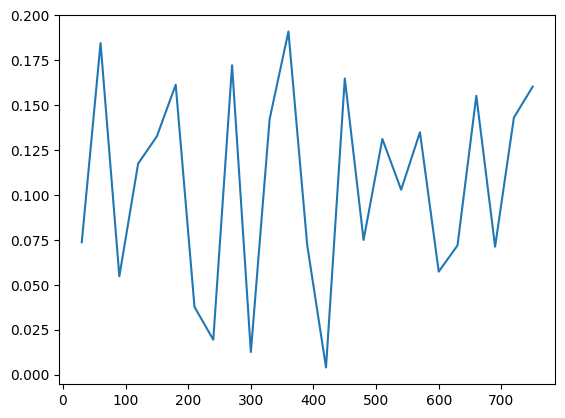

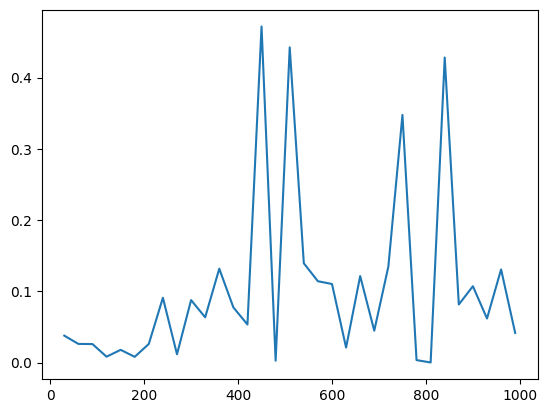

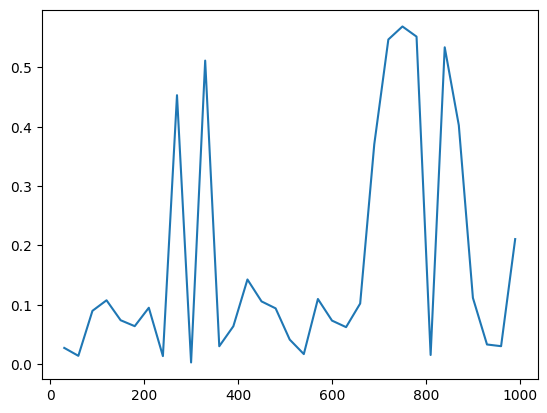

In [4]:
# save list of all mediapipe world csv files in raw pose data folders 

raw_data_full_path_all = [] 
raw_data_file_names_all = []

median_depth_est_diff_all = pd.DataFrame()

# loop through all files in input path 
for (dir_path, dir_names, file_names) in os.walk(raw_pose_data_in_path):
    for file_name in file_names: 
        name, ext = os.path.splitext(file_name)
        ext = ext.lower()[1:]
        current_raw_data_in_path = os.path.join(dir_path, file_name) # full path to files 

        # get 
        parent_path_1, current_file_name = os.path.split(current_raw_data_in_path)
        parent_path_2, current_raw_data_folder = os.path.split(parent_path_1)
        parent_path_3, current_date = os.path.split(parent_path_2)
        parent_path_4, current_id = os.path.split(parent_path_3)
        current_id_date = os.path.join(current_id, current_date)

        # select file paths with yolo data ----------------------------------------
        if (ext == 'csv') &  ('000_raw_pose_data' in current_raw_data_in_path) & ('marigold.csv' in current_raw_data_in_path): # from run.py, outputs all saved in 000_raw_pose_data_folder
            mari_df = pd.read_csv(current_raw_data_in_path, index_col = 0)

            # drop inf values without depth est 
            mari_depth_inf = np.isinf(mari_df['depth_est'])
            mari_df = mari_df[~mari_depth_inf]

            # median depth est at each frame, of all labels 
            median_depths = mari_df.groupby(['frame'])['depth_est'].median()

            # diff in median depths - change in depth est per second 
            median_depth_diff = abs(median_depths.diff())

            plt.plot(median_depth_diff)
            plt.show()

            # make df 
            depth_df = pd.DataFrame(data = {'median_depths' : median_depths, 
                                            'median_depth_diff' : median_depth_diff})

            # describe diffs in median depth 
            median_depth_diff_describe = depth_df.describe().unstack().to_frame().T
            median_depth_diff_describe.columns = ['_'.join(col).strip() for col in median_depth_diff_describe.columns]
            median_depth_diff_describe = round(median_depth_diff_describe, 2)

            median_depth_diff_describe['id_video'] = current_id 
            median_depth_diff_describe['visit_date_video'] = current_date
            median_depth_diff_describe['filename'] = current_file_name

            median_depth_est_diff_all = pd.concat([median_depth_est_diff_all, median_depth_diff_describe])
           

In [5]:
median_depth_est_diff_all.head()

,median_depths_count,median_depths_mean,median_depths_std,median_depths_min,median_depths_25%,median_depths_50%,median_depths_75%,median_depths_max,median_depth_diff_count,median_depth_diff_mean,median_depth_diff_std,median_depth_diff_min,median_depth_diff_25%,median_depth_diff_50%,median_depth_diff_75%,median_depth_diff_max,id_video,visit_date_video,filename
0,4.0,0.53,0.24,0.20,0.45,0.58,0.67,0.77,3.0,0.27,0.15,0.13,0.18,0.24,0.33,0.43,BW-0002,2022_09_12,gait_vertical_FW_1_marigold.csv
0,21.0,0.46,0.23,0.05,0.30,0.46,0.64,0.88,20.0,0.14,0.11,0.01,0.06,0.13,0.22,0.44,BW-0002,2022_09_12,gait_vertical_PWS_1_marigold.csv
0,35.0,0.47,0.19,0.01,0.40,0.50,0.61,0.74,34.0,0.10,0.10,0.00,0.03,0.08,0.13,0.45,BW-0002,2023_09_12,gait_vertical_FW_1_marigold.csv
0,45.0,0.46,0.18,0.02,0.36,0.46,0.61,0.74,44.0,0.09,0.10,0.00,0.02,0.05,0.10,0.51,BW-0002,2023_09_12,gait_vertical_PWS_1_marigold.csv
0,21.0,0.44,0.21,0.03,0.28,0.50,0.63,0.74,20.0,0.13,0.08,0.01,0.05,0.14,0.19,0.25,BW-0006,2022_09_26,gait_vertical_FW_1_marigold.csv


In [6]:
# merge with brainwalk 
# load brainwalkd data 
bw_df = pd.read_excel(r'C:\Users\mmccu\AppData\Local\Temp\ccsecure\2025_01_24_BrainWalk_AllData_Long_MM.xlsx', 
                     index_col = None, 
                     usecols = ['bw_id', 'record_id', 'trialdate', 'visit_date', 'bingoEHR_EDSS_measure_value', 'msfcEHR_T25FW SPEED AVG',
                                'PWS_velocitycmsecmean', 'FW_velocitycmsecmean'])

In [7]:
median_depth_est_diff_all['visit_date_video'] = pd.to_datetime(median_depth_est_diff_all['visit_date_video'].str.replace('_', '-'), format='%Y-%m-%d')

In [8]:
depth_est_diff_w_bw = merge_bw_zv(bw_df, median_depth_est_diff_all)

total bw rows with id in video dataset
16
mismatched zeno video vs brainwalk id
0
mismatched zeno video vs brainwalk date
0


In [9]:
def scatterplot_all_vs_one(df, column_name, output_path, folder_name):
    
    for current_col_2 in df.columns:
        clean_df = df.dropna(subset=[column_name, current_col_2])

        # consistent for all plots 
        col_1_data = clean_df[column_name]

        # loop through each other column 
        col_2_data =  clean_df[current_col_2]

        # scatterplot 
        plt.scatter(col_1_data, col_2_data, alpha = 0.5)
        plt.xlabel(column_name)
        plt.ylabel(current_col_2) 

        if not os.path.exists(os.path.join(output_path, folder_name)): 
            os.makedirs(os.path.join(output_path, folder_name))

        plt.savefig(os.path.join(output_path, folder_name, current_col_2 + '.png')) 
        plt.close()

In [10]:
plot_path = os.path.join(output_folder, 'scatterplots')
if not os.path.exists(plot_path): 
    os.makedirs(plot_path)

In [11]:
depth_est_diff_w_bw_fw = depth_est_diff_w_bw.loc[depth_est_diff_w_bw['filename'].str.contains('FW_1')]  
depth_est_diff_w_bw_pws = depth_est_diff_w_bw.loc[depth_est_diff_w_bw['filename'].str.contains('PWS_1')]

In [12]:
# plot all vars from fast walk videos vs t25fw 
scatterplot_all_vs_one(df = depth_est_diff_w_bw_fw,
                       column_name = 'msfcEHR_T25FW SPEED AVG', 
                       output_path = plot_path, 
                       folder_name = 't25fw_vs_depth_est_diff')

In [13]:
scatterplot_all_vs_one(df = depth_est_diff_w_bw_pws,
                       column_name = 'PWS_velocitycmsecmean', 
                       output_path = plot_path, 
                       folder_name = 'pws_velocity_vs_depth_est_diff')

In [14]:
scatterplot_all_vs_one(df = depth_est_diff_w_bw_fw,
                       column_name = 'FW_velocitycmsecmean', 
                       output_path = plot_path, 
                       folder_name = 'fw_velocity_vs_depth_est_diff')